In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
# Load data
coefficients = np.load('TMP_P0_L1_GLC0_Coefficients.npy').T
data_mean = np.load('TMP_P0_L1_GLC0_Mean.npy')
modes = np.load('TMP_P0_L1_GLC0_Modes.npy')

In [3]:
opt_obj_vec = []
num_cluster_range = 15
for k in range(1, num_cluster_range+1):
    model = KMeans(n_clusters=k)  
    model.fit(coefficients)
    opt_obj_vec.append(model.inertia_/coefficients.shape[0])

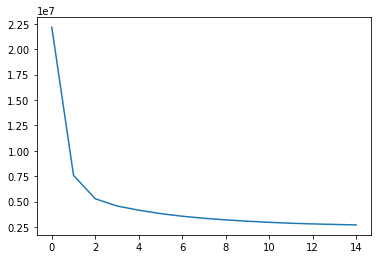

In [4]:
plt.figure()
plt.plot(opt_obj_vec)
plt.show()

In [5]:
# Final model
num_clusters = 6
model = KMeans(n_clusters=num_clusters)  
model.fit(coefficients)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

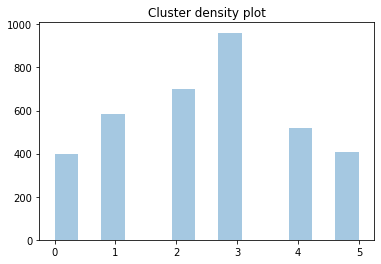

In [7]:
cluster_labels = model.labels_
cluster_centers = model.cluster_centers_

plt.figure()
ax = sns.distplot(cluster_labels,kde=False)
plt.title('Cluster density plot')
plt.show()

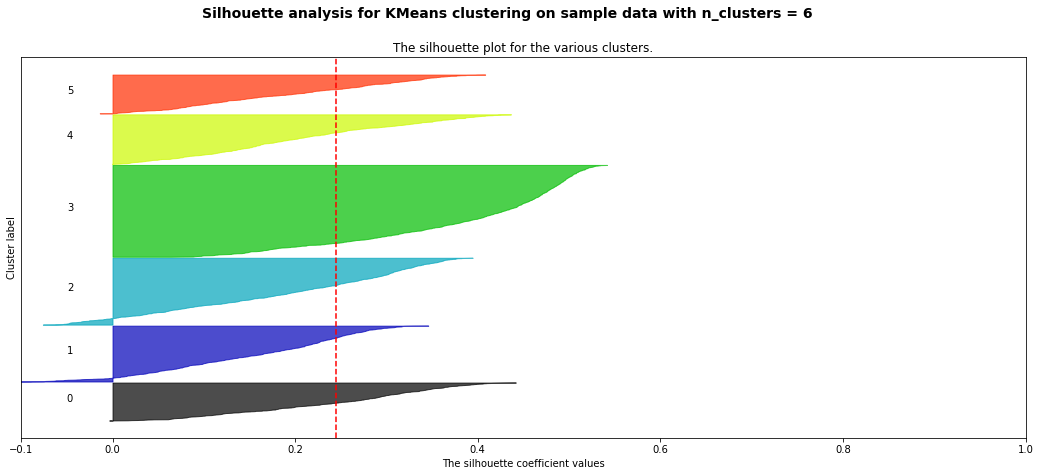

In [8]:
sample_silhouette_values = silhouette_samples(coefficients,cluster_labels)

# Create a subplot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, coefficients.shape[1] + (cluster_labels + 1) * 10])

y_lower = 10
for i in range(num_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / num_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
silhouette_avg = silhouette_score(coefficients, cluster_labels)
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % num_clusters),
             fontsize=14, fontweight='bold')
plt.show()

In [9]:
# Build transition matrix
def find_transition_matrix(labels):
    '''
    Labels should be ordered in time
    '''
    num_snapshots = labels.shape[0]
    num_states = num_clusters
    
    snapshot_matrix = np.zeros(shape=(num_states,num_states),dtype='float32')
    
    # current state x next state
    for snapshot in range(num_snapshots-1):
        snapshot_matrix[labels[snapshot],labels[snapshot+1]]+=1
    
    # Normalize
    for j in range(num_states):
        sum_states = np.sum(snapshot_matrix[j,:])
        snapshot_matrix[j,:] = snapshot_matrix[j,:]/sum_states
        
    return snapshot_matrix

In [10]:
nam_transition_matrix = find_transition_matrix(cluster_labels)

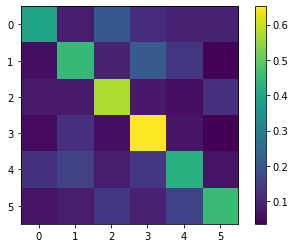

In [11]:
plt.figure()
plt.imshow(nam_transition_matrix)
plt.colorbar()
plt.show()

In [12]:
# Do visual assessments of transition
def transition_visualization(label1,label2):
    print('Probability of transition:')
    print(nam_transition_matrix[label1,label2])
    
    print('The structural transition:')
    cluster_center = cluster_centers[label1,:].T.reshape(40,-1)
    cluster_center_1 = np.matmul(modes,cluster_center).reshape(428,614) + data_mean
    
    plt.figure()
    plt.imshow(cluster_center_1,origin='lower')
    plt.colorbar()
    plt.title('From State')
    plt.show()
    
    
    cluster_center = cluster_centers[label2,:].T.reshape(40,-1)
    cluster_center_2 = np.matmul(modes,cluster_center).reshape(428,614) + data_mean
    
    plt.figure()
    plt.imshow(cluster_center_2,origin='lower')
    plt.colorbar()
    plt.title('To State')
    plt.show()
    
    plt.figure()
    plt.imshow((cluster_center_2-cluster_center_1),origin='lower')
    plt.colorbar()
    plt.title('Difference')
    plt.show()

Probability of transition:
0.13504274
The structural transition:


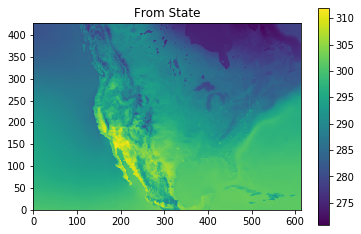

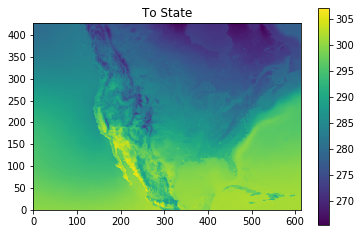

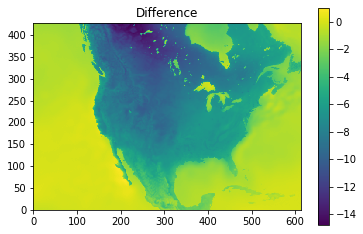

In [13]:
transition_visualization(1,4)

Probability of transition:
0.042735044
The structural transition:


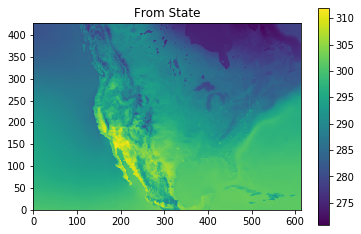

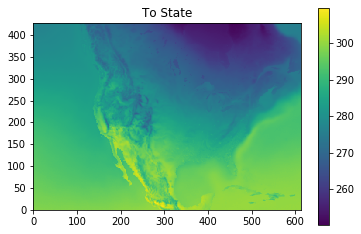

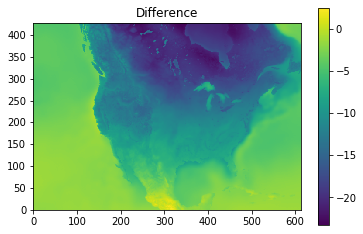

In [14]:
transition_visualization(1,5)

Probability of transition:
0.09798995
The structural transition:


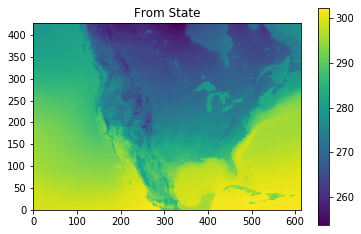

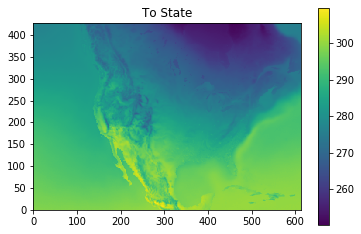

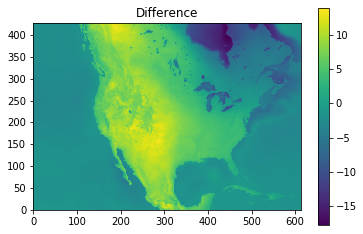

In [15]:
transition_visualization(0,5)

In [47]:
# Lets take a random walk from this transition matrix
# Not of much use here but whatever
def take_random_walk(initial_state,num_steps=365,random_sampling=False):
    '''
    random_sampling randomly samples from the identified clusters with a certain threshold of silhoette score (0.2)
    '''
    current_state = initial_state
    elements = np.arange(num_clusters,dtype='int32')
    
    walk_path = [current_state]
    
    for step in range(num_steps):
        transition_probabilities = nam_transition_matrix[current_state,:]
        next_step = np.random.choice(elements, p=transition_probabilities)
        walk_path.append(next_step)
        current_state = next_step
        
    if random_sampling:
        # Find the trajectory in physical space
        walk_path = np.asarray(walk_path)
        pod_trajectory = np.zeros(shape=(walk_path.shape[0],coefficients.shape[1]))

        # Find cluster members and membership values
        for i in range(walk_path.shape[0]):    
            cluster_members = coefficients[cluster_labels==walk_path[i]]
            cluster_silhouette_values = sample_silhouette_values[cluster_labels == walk_path[i]]

            subsamples = np.arange(cluster_members.shape[0])
            subsamples = subsamples[cluster_silhouette_values>0.2]
            cluster_members = cluster_members[subsamples]

            sample = np.random.randint(low=0,high=cluster_members.shape[0])

            pod_trajectory[i] = cluster_members[sample]

        return data_mean[:,:,None] + np.matmul(modes,pod_trajectory.T).reshape(428,614,num_steps+1)
    
    else:
        # Find the trajectory in physical space
        return data_mean[:,:,None] + np.matmul(modes,cluster_centers[np.asarray(walk_path)].T).reshape(428,614,num_steps+1)

In [48]:
initial_label = 0 # Initial state to start at
trajectories = take_random_walk(initial_label,num_steps=100,random_sampling=True)

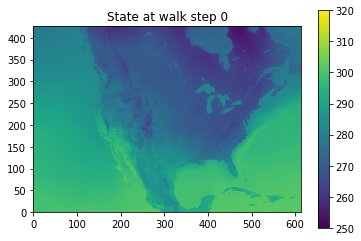

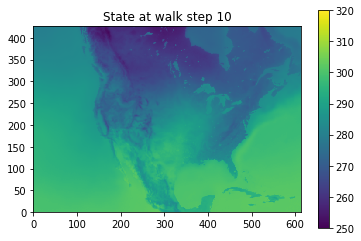

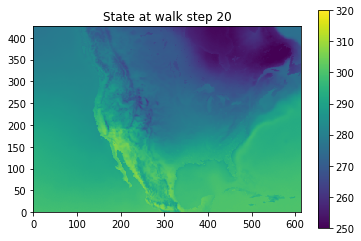

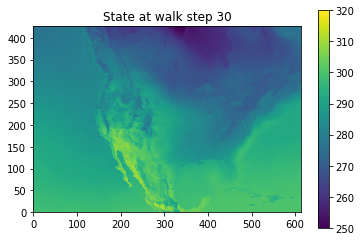

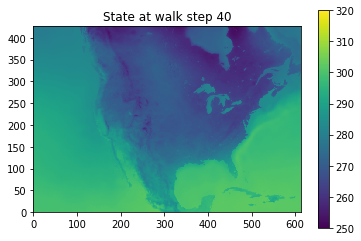

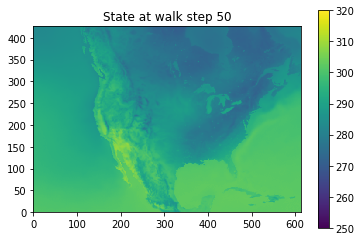

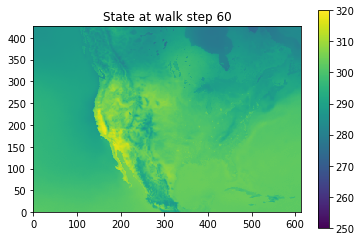

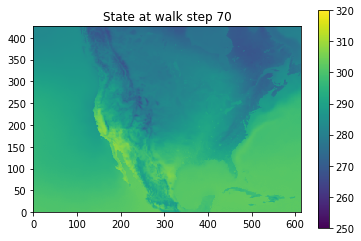

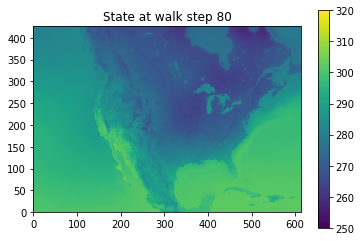

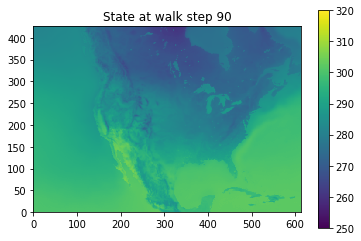

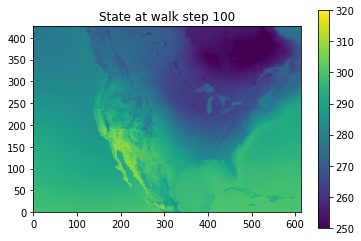

In [50]:
for step in range(0,trajectories.shape[-1],10):
    plt.figure()
    plt.imshow(trajectories[:,:,step],origin='lower',vmin=250,vmax=320)
    plt.colorbar()
    plt.title('State at walk step '+str(step))
    plt.show()